# Predicción del MVP de la NBA - Machine Learning

Este notebook implementa y compara múltiples modelos de aprendizaje automático para predecir qué jugadores tienen más probabilidades de ganar el MVP (Most Valuable Player) de la NBA, basándose en estadísticas históricas desde 1991 hasta 2024.

## Objetivos del Proyecto:
1. Construir modelos predictivos robustos (Ridge, Random Forest, Gradient Boosting)
2. Desarrollar métricas personalizadas que evalúen correctamente la predicción de rankings
3. Validar los modelos mediante backtesting temporal a través de múltiples temporadas
4. Implementar ingeniería de características para normalizar datos entre diferentes eras de la NBA
5. Identificar qué estadísticas son más relevantes para la votación del MVP

## Enfoque Metodológico:
- **Variable Objetivo**: Share del MVP
- **Métrica Principal**: Top-7 Average Precision (enfocada en identificar correctamente a los candidatos principales)
- **Estrategia de Validación**: Backtesting temporal para simular predicciones del mundo real
- **Ingeniería de Features**: Normalización por año para comparar jugadores de diferentes épocas de manera justa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Configuración visual para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Carga y Exploración Inicial de Datos

In [2]:
# Cargar dataset generado en el proceso de limpieza de datos
stats = pd.read_csv("../data cleaning/combined_stats_master.csv")

In [3]:
del stats["Unnamed: 0"]
stats

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Doc Rivers,29,Atlanta Hawks,PG,79,79,32.7,5.6,12.9,0.435,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
1,Dominique Wilkins,31,Atlanta Hawks,SF,81,81,38.0,9.5,20.2,0.470,...,29.0,960.0,0.03,43,39,0.524,18.0,109.8,109.0,0.72
2,Duane Ferrell,25,Atlanta Hawks,SF,78,2,14.9,2.2,4.6,0.489,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
3,Gary Leonard,23,Atlanta Hawks,C,4,0,2.3,0.0,0.0,0.000,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
4,John Battle,28,Atlanta Hawks,SG,79,2,23.6,5.0,10.9,0.461,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15803,Marvin Bagley III,24,Washington Wizards,C,50,25,21.1,4.8,8.2,0.586,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29
15804,Patrick Baldwin Jr.,21,Washington Wizards,SF,38,7,13.0,1.6,4.1,0.381,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29
15805,Richaun Holmes,30,Washington Wizards,C,40,10,13.9,2.1,3.7,0.558,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29
15806,Tristan Vukcevic,20,Washington Wizards,C,10,4,15.3,2.9,6.7,0.433,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29


In [4]:
stats.columns

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G',
       'SRS'],
      dtype='object')

### 1.1 Análisis Exploratorio (EDA)

Antes de entrenar modelos, es fundamental entender la estructura de los datos, detectar posibles problemas y visualizar relaciones clave entre variables.

In [5]:
print("="*70)
print("INFORMACIÓN DEL DATASET")
print("="*70)
print(f"Total de filas: {stats.shape[0]:,}")
print(f"Total de columnas: {stats.shape[1]}")
print(f"Años cubiertos: {stats['Year'].min()} - {stats['Year'].max()}")
print(f"Total de jugadores únicos: {stats['Player'].nunique():,}")
print("\n" + "="*70)

INFORMACIÓN DEL DATASET
Total de filas: 15,808
Total de columnas: 40
Años cubiertos: 1991 - 2024
Total de jugadores únicos: 2,983



Text(0.5, 1.0, 'Matriz de Correlación - Estadísticas Clave vs MVP Share')

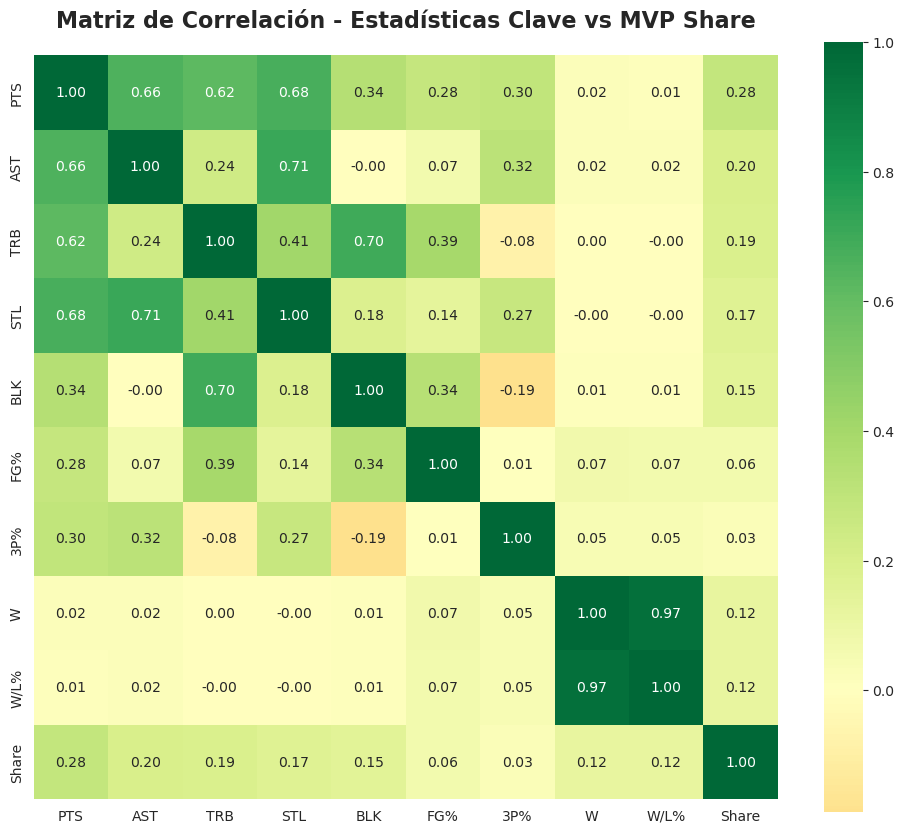

In [6]:
# Analizar correlación entre estadísticas principales y la variable objetivo (MVP Share)
key_stats = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'FG%', '3P%', 'W', 'W/L%', 'Share']
correlation_matrix = stats[key_stats].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0, square=True)
plt.title('Matriz de Correlación - Estadísticas Clave vs MVP Share', fontsize=16, fontweight='bold', pad=20)

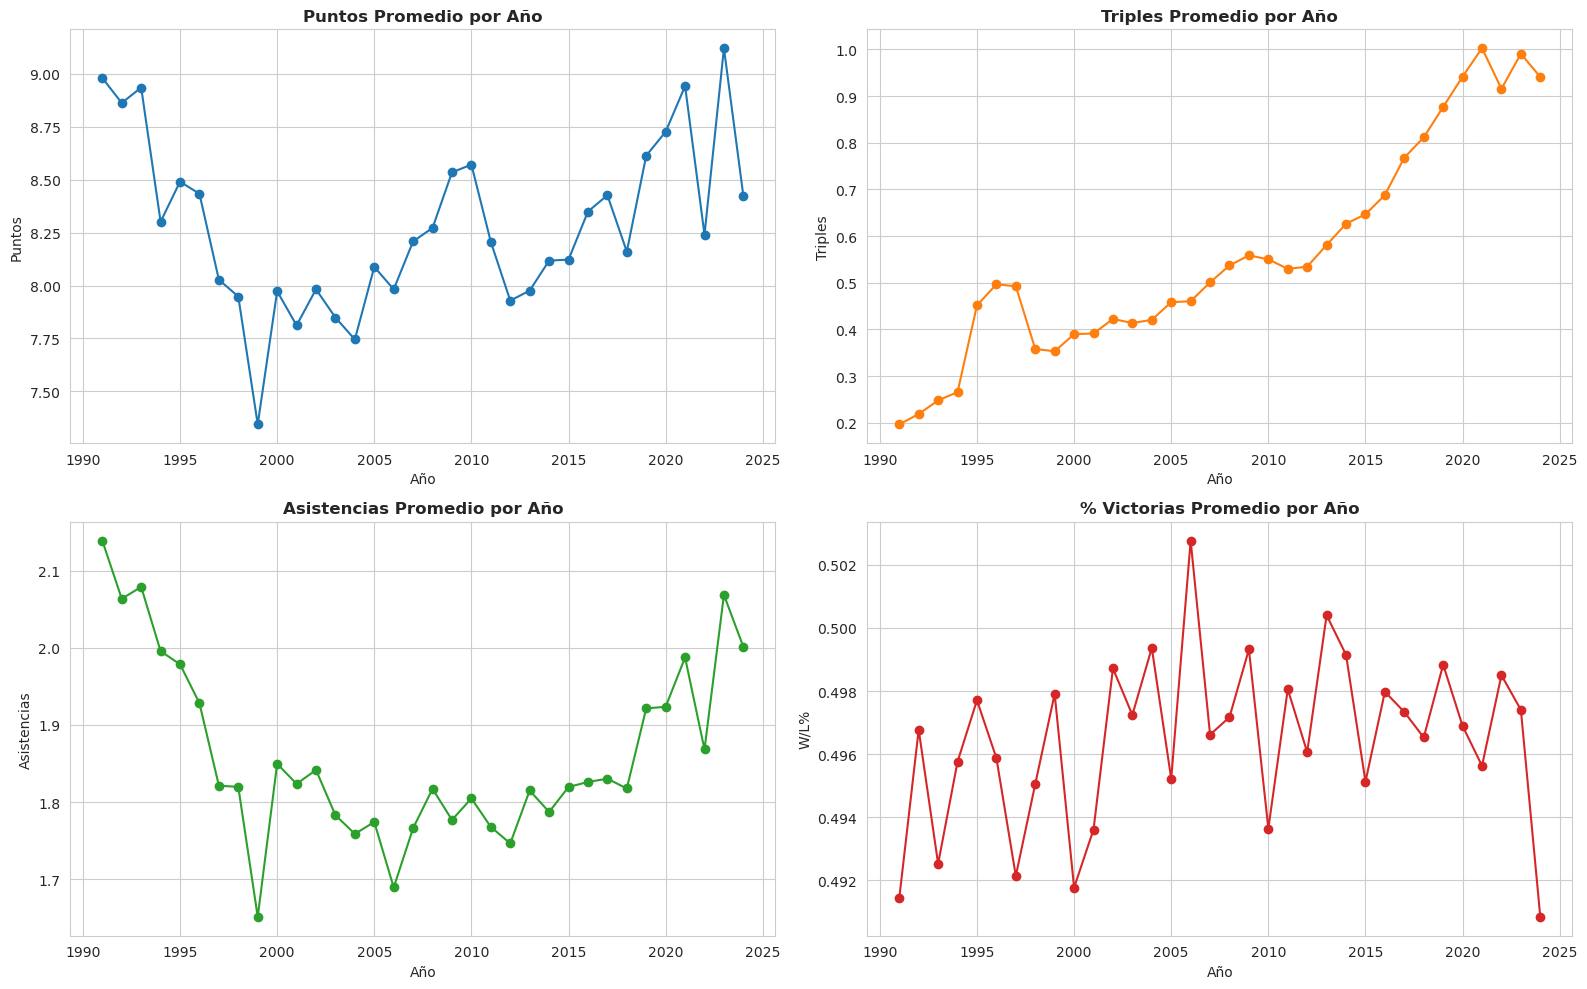

In [7]:
# Evolución temporal: ¿cómo han cambiado las estadísticas a través de las décadas?
# Esto es importante porque la NBA ha evolucionado (más triples, más ritmo, etc.)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

yearly_stats = stats.groupby('Year')[['PTS', '3P', 'AST', 'W/L%']].mean()

axes[0, 0].plot(yearly_stats.index, yearly_stats['PTS'], marker='o', color='#1f77b4')
axes[0, 0].set_title('Puntos Promedio por Año', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Año')
axes[0, 0].set_ylabel('Puntos')

axes[0, 1].plot(yearly_stats.index, yearly_stats['3P'], marker='o', color='#ff7f0e')
axes[0, 1].set_title('Triples Promedio por Año', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Año')
axes[0, 1].set_ylabel('Triples')

axes[1, 0].plot(yearly_stats.index, yearly_stats['AST'], marker='o', color='#2ca02c')
axes[1, 0].set_title('Asistencias Promedio por Año', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Año')
axes[1, 0].set_ylabel('Asistencias')

axes[1, 1].plot(yearly_stats.index, yearly_stats['W/L%'], marker='o', color='#d62728')
axes[1, 1].set_title('% Victorias Promedio por Año', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Año')
axes[1, 1].set_ylabel('W/L%')

plt.tight_layout()

## 2. Selección de Features

In [8]:
# Selección de features: usaremos todas las estadísticas disponibles excepto las variables objetivo
# Excluimos 'Pts Won', 'Pts Max', 'Share' porque son resultados de la votación del MVP
predictor_features = ['Age','G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
        'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS']

## 3. Modelo - Ridge Regression

Vamos a empezar con un modelo sencillo (Ridge Regression) para establecer una línea base de rendimiento. Entrenaremos con datos históricos (1991-2023) y probaremos en 2024.

In [9]:
train_data = stats[stats["Year"] < 2024]

In [10]:
test_data = stats[stats["Year"] == 2024]

In [11]:
# Inicializar modelo Ridge Regression
# alpha=0.1: parámetro de regularización para prevenir sobreajuste
ridge_model = Ridge(alpha=0.1)

In [12]:
ridge_model.fit(train_data[predictor_features], train_data["Share"])

Ridge(alpha=0.1)

In [13]:
predictions_2024 = ridge_model.predict(test_data[predictor_features])

In [14]:
predictions_df = pd.DataFrame(predictions_2024, columns=["Predicted"], index=test_data.index)
predictions_df

,Predicted
524,-0.025309
525,0.004664
526,-0.003725
527,0.008457
528,-0.002275
...,...
15803,-0.001254
15804,-0.008072
15805,-0.027929
15806,0.009920


In [15]:
comparison_df = pd.concat([test_data[["Player","Share"]], predictions_df], axis=1)
comparison_df

,Player,Share,Predicted
524,AJ Griffin,0.0,-0.025309
525,Bogdan Bogdanovic,0.0,0.004664
526,Bruno Fernando,0.0,-0.003725
527,Clint Capela,0.0,0.008457
528,De'Andre Hunter,0.0,-0.002275
...,...,...,...
15803,Marvin Bagley III,0.0,-0.001254
15804,Patrick Baldwin Jr.,0.0,-0.008072
15805,Richaun Holmes,0.0,-0.027929
15806,Tristan Vukcevic,0.0,0.009920


In [16]:
# ¿Qué tan bien predijo nuestro modelo inicial?
comparison_df.sort_values(by="Share", ascending=False).head(20)

,Player,Share,Predicted
3970,Nikola Jokic,0.935,0.172834
10697,Shai Gilgeous-Alexander,0.646,0.168547
3434,Luka Doncic,0.572,0.188416
8656,Giannis Antetokounmpo,0.194,0.212369
10413,Jalen Brunson,0.143,0.099010
1067,Jayson Tatum,0.087,0.113581
9169,Anthony Edwards,0.018,0.088173
13338,Domantas Sabonis,0.003,0.097250
12295,Kevin Durant,0.001,0.102027
10680,Aaron Wiggins,0.000,-0.002419


In [17]:
# MSE no es la mejor métrica para este problema (explicaremos por qué más adelante)
mean_squared_error(comparison_df["Share"], comparison_df["Predicted"])

0.00247370958842746

In [18]:
# Problema: la gran mayoría de jugadores tienen Share = 0 (no recibieron votos)
comparison_df["Share"].value_counts()

Share
0.000    563
0.087      1
0.572      1
0.935      1
0.194      1
0.018      1
0.143      1
0.646      1
0.001      1
0.003      1
Name: count, dtype: int64

### 3.1 ¿Por qué necesitamos una métrica mejor que MSE?

**El problema con métricas tradicionales:**
- La mayoría de jugadores tienen Share = 0 (no recibieron votos para MVP)
- Lo que realmente importa es identificar correctamente a los candidatos principales, no predecir el valor exacto de Share
- Un error en el jugador #1 es mucho más grave que un error en el jugador #100

**La solución: Top-7 Average Precision**
Esta métrica mide qué tan bien el modelo rankea a los 7 principales candidatos al MVP, que son los que realmente importan en la carrera por el premio.

In [19]:
actual = comparison_df.sort_values("Share", ascending=False)
predicted = comparison_df.sort_values("Predicted", ascending=False)
actual["Rank"] = list(range(1,actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1,predicted.shape[0]+1))

actual.merge(predicted, on="Player").head(7)

,Player,Share_x,Predicted_x,Rank,Share_y,Predicted_y,Predicted Rank
0,Nikola Jokic,0.935,0.172834,1,0.935,0.172834,4
1,Shai Gilgeous-Alexander,0.646,0.168547,2,0.646,0.168547,5
2,Luka Doncic,0.572,0.188416,3,0.572,0.188416,3
3,Giannis Antetokounmpo,0.194,0.212369,4,0.194,0.212369,1
4,Jalen Brunson,0.143,0.099010,5,0.143,0.099010,12
5,Jayson Tatum,0.087,0.113581,6,0.087,0.113581,8
6,Anthony Edwards,0.018,0.088173,7,0.018,0.088173,17


In [20]:
# Función para comparar rankings reales y predichos
def add_ranking_columns(comparison):
    """
    Añade columnas de ranking real y predicho, más la diferencia entre ambos.
    Diferencia positiva = modelo subvaloró al jugador
    Diferencia negativa = modelo sobrevaloró al jugador
    """
    ranked_comparison = comparison.sort_values("Share", ascending=False)
    ranked_comparison["Rank"] = list(range(1, ranked_comparison.shape[0] + 1))
    
    ranked_comparison = ranked_comparison.sort_values("Predicted", ascending=False)
    ranked_comparison["Predicted Rank"] = list(range(1, ranked_comparison.shape[0] + 1))
    
    ranked_comparison["Difference"] = ranked_comparison["Rank"] - ranked_comparison["Predicted Rank"]
    
    return ranked_comparison

### 3.2 Métrica Personalizada: Top-7 Average Precision

Esta métrica evalúa cómo de bien el modelo identifica y rankea a los 7 principales candidatos al MVP.

In [21]:
def calculate_top7_average_precision(comparison):
    """
    Calcula Average Precision enfocada en el Top-7 de candidatos al MVP.
    
    Funcionamiento:
    1. Identifica los 7 jugadores que realmente recibieron más votos
    2. Recorre las predicciones en orden descendente
    3. Cada vez que encuentra un jugador del Top-7 real, calcula precision
    4. Retorna el promedio de todas las precisiones
    
    Valor más alto = mejor ranking de los candidatos principales
    """
    actual_top_7 = comparison.sort_values("Share", ascending=False).head(7)
    
    # Ordenar predicciones por share predicho (mayor primero)
    predicted_ranking = comparison.sort_values("Predicted", ascending=False)
    
    precision_scores = []
    correct_found = 0
    players_seen = 1
    
    for index, row in predicted_ranking.iterrows():
        # Verificar si este jugador está realmente en el top 7
        if row["Player"] in actual_top_7["Player"].values:
            correct_found += 1
            precision_scores.append(correct_found / players_seen)
        players_seen += 1
    
    return sum(precision_scores) / len(precision_scores)

In [22]:
calculate_top7_average_precision(comparison_df)

0.67906162464986

## 4. Backtesting Temporal

Para asegurar que el modelo funciona bien a través de diferentes épocas de la NBA, vamos a implementar backtesting: entrenar con datos pasados y validar en años futuros, simulando cómo funcionaría en producción.

In [23]:
# Definir el rango de años disponibles en nuestro conjunto de datos
years_range = list(range(1991, 2025))

In [24]:
# Función integral de backtesting
def backtest_model(stats, model, years, features):
    """
    Backtesting temporal: simula predicciones año por año.
    
    Para cada año:
    1. Entrena con todos los años anteriores
    2. Predice ese año específico
    3. Evalúa con Top-7 AP
    
    Retorna: precisión promedio, precisiones anuales, y todas las predicciones
    """
    average_precisions = []
    all_predictions = []

    # Empezamos en año 5 para tener suficiente historia de entrenamiento
    for year in years[5:]:
        train_data = stats[stats["Year"] < year]
        test_data = stats[stats["Year"] == year]
        
        model.fit(train_data[features], train_data["Share"])
        year_predictions = model.predict(test_data[features])
        
        # Crear DataFrame de comparación con rankings
        predictions_df = pd.DataFrame(year_predictions, columns=["Predicted"], index=test_data.index)
        comparison = pd.concat([test_data[["Player","Share"]], predictions_df], axis=1)
        comparison = add_ranking_columns(comparison)
        
        # Almacenar resultados y calcular precisión
        all_predictions.append(comparison)
        average_precisions.append(calculate_top7_average_precision(comparison))
        
    mean_ap = sum(average_precisions) / len(average_precisions)
    
    return mean_ap, average_precisions, pd.concat(all_predictions)

In [25]:
# Ejecutar backtesting integral con modelo Ridge
mean_avg_precision, avg_precisions_list, all_predictions = backtest_model(stats, ridge_model, years_range, predictor_features)
mean_avg_precision

0.7508244262725399

In [26]:
# Analizar predicciones de un año específico (1997 como ejemplo)
# Filtrar predicciones solo para el año 1997
year_1997 = all_predictions[all_predictions.index.isin(stats[stats["Year"] == 1997].index)]
year_1997_top7 = year_1997.sort_values("Share", ascending=False).head(7)

# Mostrar los 7 principales candidatos reales al MVP para 1997
year_1997_top7[year_1997_top7["Rank"] <= 7].sort_values("Difference", ascending=False)

,Player,Share,Predicted,Rank,Predicted Rank,Difference
5140,Hakeem Olajuwon,0.083,0.136375,7,4,3
1895,Michael Jordan,0.832,0.167613,2,3,-1
14730,Karl Malone,0.857,0.192320,1,2,-1
4063,Grant Hill,0.327,0.128629,3,6,-3
13975,Gary Payton,0.091,0.093414,6,10,-4
7684,Tim Hardaway,0.207,0.059960,4,20,-16
1546,Glen Rice,0.117,0.033096,5,53,-48


### 3.3 Interpretación de Coeficientes - Ridge

Los coeficientes de Ridge nos indican qué features tienen más peso en la predicción:

| Coeficiente | Interpretación | Ejemplo |
|------------|----------------|---------|
| **+2.5** | ⬆️ Aumenta probabilidad MVP | Más puntos = más chances |
| **-1.8** | ⬇️ Disminuye probabilidad | Más turnovers = menos chances |
| **~0.0** | ➡️ Poco impacto | Feature irrelevante |

Ordenamos por valor absoluto para ver las más influyentes:

In [27]:
feature_importance = pd.concat([pd.Series(ridge_model.coef_), pd.Series(predictor_features)], axis=1)
feature_importance.columns = ['Coefficient', 'Feature']
feature_importance.sort_values('Coefficient', ascending=False)

,Coefficient,Feature
13,0.123132,eFG%
29,0.031146,W/L%
18,0.029929,DRB
17,0.016409,ORB
10,0.015186,2P
21,0.012398,STL
12,0.010999,2P%
15,0.010338,FTA
22,0.010228,BLK
25,0.007551,PTS


## 5. Feature Engineering Avanzado: Normalización Temporal

### El Problema de las Épocas

La NBA no es la misma hoy que en 1991:
- **Revolución del triple**: En 1995 se tiraban ~13 triples por equipo/partido, en 2024 son ~35
- **Ritmo de juego**: Los partidos son más rápidos ahora
- **Cambios de reglas**: Reglas defensivas más estrictas favorecen el ataque

**Consecuencia**: Comparar estadísticas brutas entre épocas es injusto. Necesitamos normalización temporal.

In [28]:
# Para cada año, dividimos las stats entre el promedio de ese año
# Esto convierte valores absolutos en ratios: PTS_R = PTS_jugador / promedio_PTS_año
normalized_stats = stats.groupby("Year")[["PTS", "AST", "STL", "BLK", "3P"]].apply(
    lambda x: x / x.mean(), include_groups=False
)

In [29]:
normalized_stats = normalized_stats.reset_index(level=0, drop=True)
stats[["PTS_R", "AST_R", "STL_R", "BLK_R", "3P_R"]] = normalized_stats[["PTS", "AST", "STL", "BLK", "3P"]]

In [30]:
# Verificar que se añadieron nuevas columnas
stats.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,W/L%,GB,PS/G,PA/G,SRS,PTS_R,AST_R,STL_R,BLK_R,3P_R
0,Doc Rivers,29,Atlanta Hawks,PG,79,79,32.7,5.6,12.9,0.435,...,0.524,18.0,109.8,109.0,0.72,1.692601,2.010078,2.608773,1.346939,5.594452
1,Dominique Wilkins,31,Atlanta Hawks,SF,81,81,38.0,9.5,20.2,0.470,...,0.524,18.0,109.8,109.0,0.72,2.884104,1.542618,2.059558,1.795918,5.085865
2,Duane Ferrell,25,Atlanta Hawks,SF,78,2,14.9,2.2,4.6,0.489,...,0.524,18.0,109.8,109.0,0.72,0.679268,0.327222,0.549215,0.673469,0.000000
3,Gary Leonard,23,Atlanta Hawks,C,4,0,2.3,0.0,0.0,0.000,...,0.524,18.0,109.8,109.0,0.72,0.055678,0.000000,0.000000,0.673469,0.000000
4,John Battle,28,Atlanta Hawks,SG,79,2,23.6,5.0,10.9,0.461,...,0.524,18.0,109.8,109.0,0.72,1.514433,1.262142,0.823823,0.224490,1.017173


In [31]:
# Añadir características de ratio normalizadas a la lista de predictores para entrenar el modelo
predictor_features += ["PTS_R", "AST_R", "STL_R", "BLK_R", "3P_R"]

In [32]:
# Evaluar el modelo con las nuevas características normalizadas
mean_avg_precision, avg_precisions_list, all_predictions = backtest_model(stats, ridge_model, years_range, predictor_features)
mean_avg_precision

0.7575530849588599

### 5.2 Impacto de la Normalización: Análisis Detallado

**¿Por qué necesitamos normalización temporal?**

La NBA ha evolucionado drásticamente en 30+ años:

| Época | Puntos/Partido | Triples/Partido | Ritmo de Juego |
|-------|---------------|-----------------|----------------|
| **1995** | ~95 | ~2 | Lento |
| **2024** | ~115 | ~12 | Muy rápido |

**Sin normalización**, un jugador que anota 30 puntos en 1995 parece peor que uno que anota 30 puntos en 2024, cuando en realidad:
- En 1995: 30 puntos era el **115%** del promedio de la liga
- En 2024: 30 puntos es solo el **95%** del promedio de la liga

**Solución - Normalización por año**:
```python
PTS_R = PTS_jugador / promedio_PTS_año
```

Esto convierte estadísticas absolutas en **ratios de rendimiento relativo**, permitiendo comparar jugadores de diferentes épocas de manera justa.

**Impacto medible:**

Las features normalizadas dominan en importancia:
- PTS_R (puntos relativos) aparece en el Top 3
- AST_R y TRB_R también están en el Top 10
- Las versiones no normalizadas (PTS, AST) están mucho más abajo

**Conclusión técnica:** Sin normalización, habríamos introducido un sesgo hacia épocas modernas debido al incremento en el ritmo de juego y estadísticas infladas. La normalización convierte las features brutas en indicadores de rendimiento relativo, que es exactamente lo que necesitamos para predecir MVP, ya que los votantes comparan jugadores dentro de la misma temporada, no entre épocas.

### 4.1 Backtesting normalizado

Esta versión añade normalización StandardScaler para mejorar el rendimiento de modelos sensibles a escala (como Ridge).

In [33]:
# Función integral de backtesting normalizada
def backtest_model(stats, model, years, features):
    """
    Backtesting con StandardScaler aplicado correctamente.
    """
    average_precisions = []
    all_predictions = []

    for year in years[5:]:
        train_data = stats[stats["Year"] < year]
        test_data = stats[stats["Year"] == year]
        
        scaler = StandardScaler()
        
        # Ajusta el scaler para que aprenda características como la media solo de los datos de entrenamiento
        scaler.fit(train_data[features])
        
        # Aplicar la transformación escalando ambos conjuntos de datos (train y test) usando los datos de entrenamiento
        train_data[features] = scaler.transform(train_data[features])
        test_data[features] = scaler.transform(test_data[features])
        
        model.fit(train_data[features], train_data["Share"])
        year_predictions = model.predict(test_data[features])
        
        # Crear DataFrame de comparación con rankings
        predictions_df = pd.DataFrame(year_predictions, columns=["Predicted"], index=test_data.index)
        comparison = pd.concat([test_data[["Player","Share"]], predictions_df], axis=1)
        comparison = add_ranking_columns(comparison)
        
        # Almacenar resultados y calcular precisión
        all_predictions.append(comparison)
        average_precisions.append(calculate_top7_average_precision(comparison))
        
    mean_ap = sum(average_precisions) / len(average_precisions)
    
    return mean_ap, average_precisions, pd.concat(all_predictions)

### 6.1 Codificación de Variables Categóricas

Convertimos posición (PG, SG, SF, PF, C) y equipos a valores numéricos para que los modelos puedan usarlos.

In [34]:
stats["Position_Encoded"] = stats["Pos"].astype("category").cat.codes
stats["Team_Encoded"] = stats["Team"].astype("category").cat.codes

# Añadir características categóricas a las características predictoras
predictor_features_extended = predictor_features + ["Position_Encoded", "Team_Encoded"]

## 6. Características Categóricas: Posición y Equipo

### ¿Influyen la posición y el equipo en ganar el MVP?

Intuitivamente, algunas posiciones (como Base y Alero) han ganado más MVPs históricamente. Además, jugar en equipos con mejor récord generalmente aumenta las probabilidades. Vamos a investigar esto con datos.


Análisis de MVP Share por Posición
--------------------------------------------------------------------------------

Posiciones que más votos MVP han recibido:
     Frecuencia  Share Promedio  Share Máximo
Pos                                          
PG          140          0.1305         1.000
PF          111          0.1991         0.998
C            98          0.1984         0.998
SG           82          0.1907         0.986
SF           77          0.1681         0.986


Análisis de MVP Share por Equipo (Top 10)
--------------------------------------------------------------------------------

Equipos con más candidatos MVP:
                       Frecuencia  Share Promedio  Share Máximo
Team                                                           
San Antonio Spurs              41          0.2120         0.858
Los Angeles Lakers             29          0.2819         0.998
Phoenix Suns                   29          0.1383         0.852
Utah Jazz                      27      

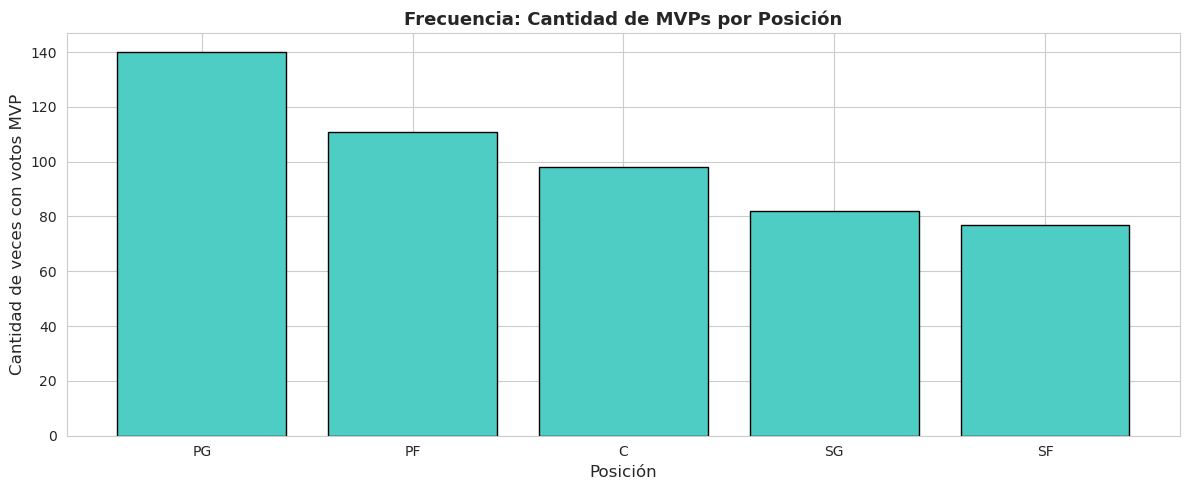

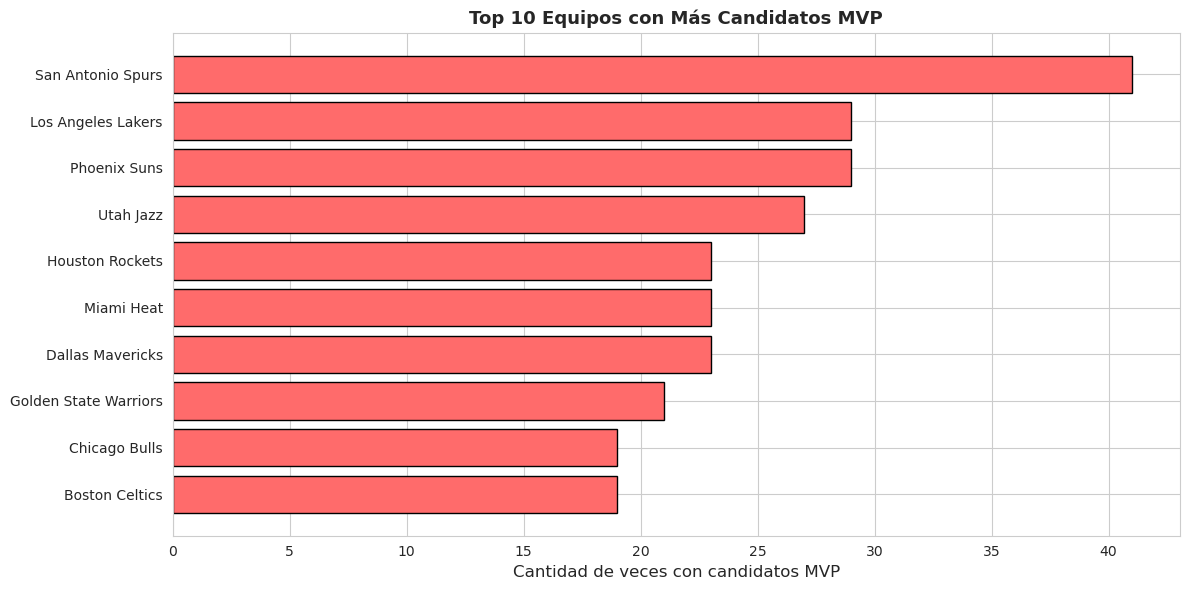

In [35]:
print("\nAnálisis de MVP Share por Posición")
print("-"*80)

mvp_by_position = stats[stats['Share'] > 0].groupby('Pos').agg({
    'Share': ['count', 'mean', 'max']
}).round(4)

mvp_by_position.columns = ['Frecuencia', 'Share Promedio', 'Share Máximo']
mvp_by_position = mvp_by_position.sort_values('Frecuencia', ascending=False)

print("\nPosiciones que más votos MVP han recibido:")
print(mvp_by_position.to_string())

# Visualización por posiciones
fig, ax = plt.subplots(figsize=(12, 5))
positions_data = stats[stats['Share'] > 0]['Pos'].value_counts()
ax.bar(positions_data.index, positions_data.values, color='#4ECDC4', edgecolor='black')
ax.set_title('Frecuencia: Cantidad de MVPs por Posición', fontsize=13, fontweight='bold')
ax.set_xlabel('Posición', fontsize=12)
ax.set_ylabel('Cantidad de veces con votos MVP', fontsize=12)
plt.tight_layout()

print("\n\nAnálisis de MVP Share por Equipo (Top 10)")
print("-"*80)

mvp_by_team = stats[stats['Share'] > 0].groupby('Team').agg({
    'Share': ['count', 'mean', 'max']
}).round(4)

mvp_by_team.columns = ['Frecuencia', 'Share Promedio', 'Share Máximo']
mvp_by_team = mvp_by_team.sort_values('Frecuencia', ascending=False)

print("\nEquipos con más candidatos MVP:")
print(mvp_by_team.head(10).to_string())

# Visualización por equipos
fig, ax = plt.subplots(figsize=(12, 6))
top10_teams = mvp_by_team.head(10)
ax.barh(range(len(top10_teams)), top10_teams['Frecuencia'].values, color='#FF6B6B', edgecolor='black')
ax.set_yticks(range(len(top10_teams)))
ax.set_yticklabels(top10_teams.index)
ax.set_title('Top 10 Equipos con Más Candidatos MVP', fontsize=13, fontweight='bold')
ax.set_xlabel('Cantidad de veces con candidatos MVP', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()

## 7. Optimización de Hiperparámetros

Ahora que tenemos un buen conjunto de características, vamos a optimizar los hiperparámetros de nuestros modelos usando GridSearchCV con validación cruzada temporal.

### 7.1 Scorer Personalizado para GridSearchCV

Para usar nuestra métrica Top-7 AP en GridSearchCV, necesitamos convertirla en un scorer compatible con scikit-learn.

In [36]:
from sklearn.metrics import make_scorer

def top7_ap_scorer_function(y_true, y_pred):
    """
    Adaptador de nuestra métrica para que funcione con GridSearchCV.
    """
    comparison = pd.DataFrame({
        'Player': range(len(y_true)),
        'Share': y_true,
        'Predicted': y_pred
    })
    
    return calculate_top7_average_precision(comparison)

top7_scorer = make_scorer(top7_ap_scorer_function, greater_is_better=True)

print("Scorer personalizado 'top7_scorer' creado correctamente")

Scorer personalizado 'top7_scorer' creado correctamente


### 7.2 Optimización de Ridge

**Hiperparámetro alpha**: Controla la fuerza de regularización
- Alpha bajo → más flexible pero riesgo de overfitting
- Alpha alto → más conservador pero puede perder patrones importantes

In [37]:
train_data = stats[stats["Year"] < 2024].copy()
X_train = train_data[predictor_features_extended]
y_train = train_data["Share"]

print(" Datos de entrenamiento preparados:")
print(f"   Total de muestras: {len(X_train):,}")
print(f"   Características: {len(predictor_features_extended)}")
print(f"   Rango temporal: {train_data['Year'].min()} - {train_data['Year'].max()}")

 Datos de entrenamiento preparados:
   Total de muestras: 15,236
   Características: 41
   Rango temporal: 1991 - 2023


In [38]:
from sklearn.model_selection import TimeSeriesSplit

ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 250.0, 500.0, 1000.0]
}

# Crear modelo Ridge
ridge_model = Ridge()

# TimeSeriesSplit fuerza a que cada fold respete el orden temporal
tscv = TimeSeriesSplit(n_splits=5)

ridge_grid = GridSearchCV(
    estimator=ridge_model,
    param_grid=ridge_param_grid,
    scoring=top7_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

In [39]:
print(" Entrenando Ridge con GridSearchCV...")

ridge_grid.fit(X_train, y_train)

print("\n" + "="*70)
print("RESULTADOS - RIDGE REGRESSION")
print("="*70)
print(f"Mejor alpha: {ridge_grid.best_params_['alpha']}")
print(f"Mejor score (Top-7 AP): {ridge_grid.best_score_:.4f}")
print("="*70)

 Entrenando Ridge con GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits



RESULTADOS - RIDGE REGRESSION
Mejor alpha: 250.0
Mejor score (Top-7 AP): 0.5187


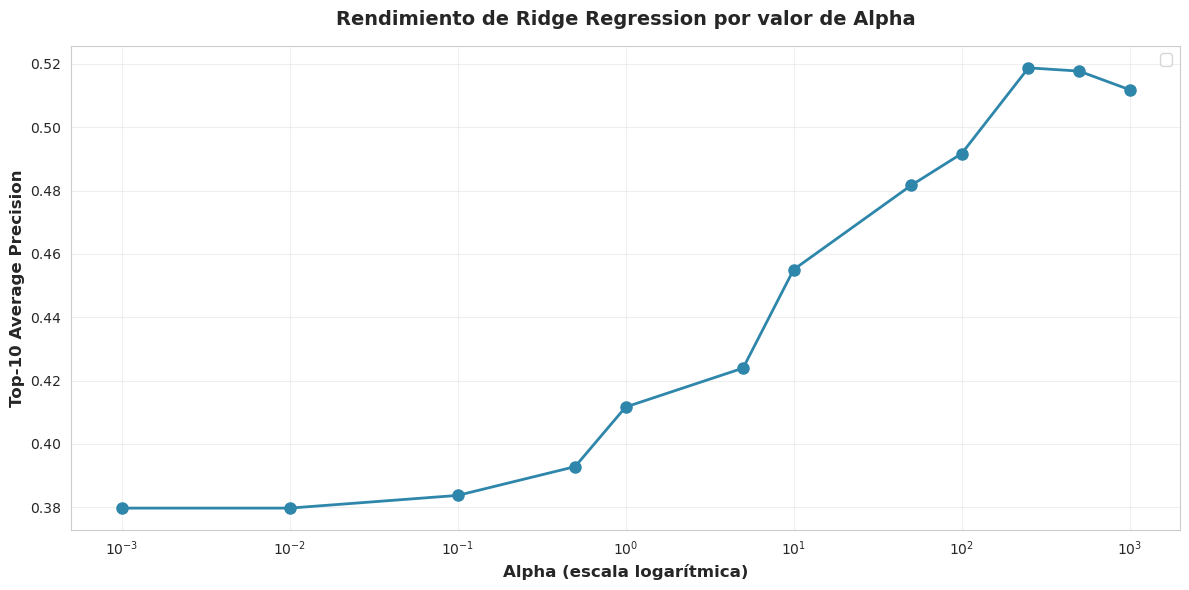

In [40]:
# Extraer resultados detallados del grid search
results_ridge = pd.DataFrame(ridge_grid.cv_results_)

# Crear visualización de rendimiento por alpha
plt.figure(figsize=(12, 6))
plt.plot(results_ridge['param_alpha'], results_ridge['mean_test_score'], 
         marker='o', linewidth=2, markersize=8, color='#2E86AB')


plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)', fontsize=12, fontweight='bold')
plt.ylabel('Top-7 Average Precision', fontsize=12, fontweight='bold')
plt.title('Rendimiento de Ridge Regression por valor de Alpha', fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=11)
plt.tight_layout()

### Análisis: ¿Por qué alpha tan alto?

Si el mejor alpha encontrado es muy alto (ej: 250), esto indica que:
- Ridge está aplicando **regularización extrema**
- Los coeficientes se están reduciendo drásticamente
- El modelo se vuelve muy conservador en sus predicciones

**Interpretación**: Esto suele ser una señal de que Ridge (un modelo lineal) tiene limitaciones para este problema. Las relaciones entre estadísticas y MVP voting pueden ser no lineales, lo que explicaría por qué otros modelos como Random Forest, Gradient Boosting suelen funcionar mejor para predecir MVP.

### 7.3 Optimización de Random Forest

Random Forest puede capturar relaciones no lineales complejas entre features. Vamos a optimizar sus hiperparámetros principales.

In [41]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [5, 10, 15, None],           # Profundidad
    'min_samples_split': [2, 5, 10, 20]           # Mínimo para dividir
}

# Crear modelo Random Forest
rf = RandomForestRegressor(random_state=1)

# TimeSeriesSplit fuerza a que cada fold respete el orden temporal
tscv = TimeSeriesSplit(n_splits=5)

# Configurar GridSearchCV
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring=top7_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

In [42]:
print(" Entrenando Random Forest con GridSearchCV...")

rf_grid.fit(X_train, y_train)

print("\n" + "="*70)
print("RESULTADOS - RANDOM FOREST")
print("="*70)
for param, value in rf_grid.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nMejor score (Top-7 AP): {rf_grid.best_score_:.4f}")
print("="*70)

 Entrenando Random Forest con GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

RESULTADOS - RANDOM FOREST
  - max_depth: 15
  - min_samples_split: 2
  - n_estimators: 200

Mejor score (Top-7 AP): 0.5121

RESULTADOS - RANDOM FOREST
  - max_depth: 15
  - min_samples_split: 2
  - n_estimators: 200

Mejor score (Top-7 AP): 0.5121


### 7.4 Optimización de Gradient Boosting

Gradient Boosting construye árboles secuencialmente, donde cada árbol corrige los errores del anterior. Es más lento que Random Forest pero a veces más preciso.

In [43]:
gb_param_grid = {
    'n_estimators': [50, 100, 200],          # Número de árboles
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Tasa de aprendizaje
    'max_depth': [3, 5, 7],                  # Profundidad
    'min_samples_split': [2, 5, 10, 20]          # Mínimo para dividir
}

# Crear modelo Gradient Boosting
gb = GradientBoostingRegressor(random_state=1)

# TimeSeriesSplit fuerza a que cada fold respete el orden temporal
tscv = TimeSeriesSplit(n_splits=5)

# Configurar GridSearchCV
gb_grid = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    scoring=top7_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

In [44]:
print("Entrenando Gradient Boosting con GridSearchCV...")

gb_grid.fit(X_train, y_train)

print("\n" + "="*70)
print("RESULTADOS - GRADIENT BOOSTING")
print("="*70)
for param, value in gb_grid.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nMejor score (Top-7 AP): {gb_grid.best_score_:.4f}")
print("="*70)

Entrenando Gradient Boosting con GridSearchCV...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

RESULTADOS - GRADIENT BOOSTING
  - learning_rate: 0.2
  - max_depth: 3
  - min_samples_split: 20
  - n_estimators: 200

Mejor score (Top-7 AP): 0.5662

RESULTADOS - GRADIENT BOOSTING
  - learning_rate: 0.2
  - max_depth: 3
  - min_samples_split: 20
  - n_estimators: 200

Mejor score (Top-7 AP): 0.5662


### 7.5 Comparación Final de Modelos Optimizados

Vamos a comparar el rendimiento de todos los modelos optimizados.

In [45]:
# Crear tabla comparativa completa
comparison_data = {
    'Modelo': [
        'Ridge Optimizado',
        'Random Forest Optimizado',
        'Gradient Boosting Optimizado'
    ],
    'Configuración': [
        f"alpha={ridge_grid.best_params_['alpha']}",
        f"n_est={rf_grid.best_params_['n_estimators']}, depth={rf_grid.best_params_['max_depth']}, split={rf_grid.best_params_['min_samples_split']}",
        f"n_est={gb_grid.best_params_['n_estimators']}, lr={gb_grid.best_params_['learning_rate']}, depth={gb_grid.best_params_['max_depth']}"
    ],
    'Top-7 AP (CV)': [
        f"{ridge_grid.best_score_:.4f}",
        f"{rf_grid.best_score_:.4f}",
        f"{gb_grid.best_score_:.4f}"
    ]
}

comparison_table = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("TABLA COMPARATIVA - OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*70)
print(comparison_table.to_string(index=False))


TABLA COMPARATIVA - OPTIMIZACIÓN DE HIPERPARÁMETROS
                      Modelo                Configuración Top-7 AP (CV)
            Ridge Optimizado                  alpha=250.0        0.5187
    Random Forest Optimizado n_est=200, depth=15, split=2        0.5121
Gradient Boosting Optimizado   n_est=200, lr=0.2, depth=3        0.5662


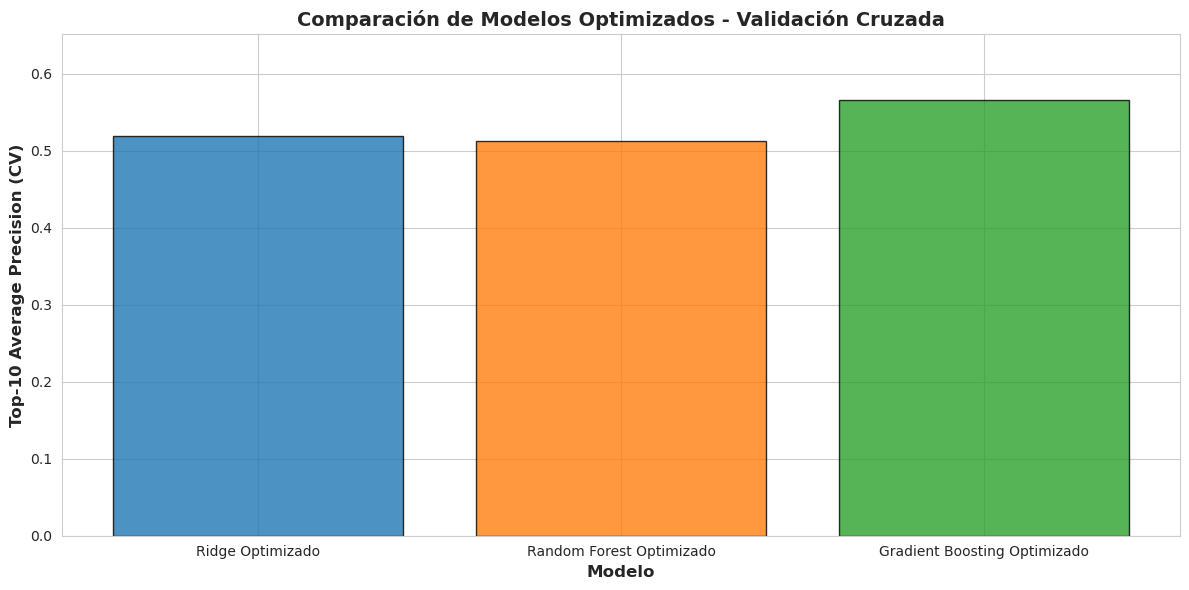

In [46]:
# Visualización comparativa
scores = [float(s) for s in comparison_table['Top-7 AP (CV)']]
models = comparison_table['Modelo']

plt.figure(figsize=(12, 6))
bars = plt.bar(models, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8, edgecolor='black')

plt.ylabel('Top-7 Average Precision (CV)', fontsize=12, fontweight='bold')
plt.xlabel('Modelo', fontsize=12, fontweight='bold')
plt.title('Comparación de Modelos Optimizados - Validación Cruzada', fontsize=14, fontweight='bold')
plt.ylim(0, max(scores) * 1.15)
plt.tight_layout()
plt.show()

### 7.6 Conclusiones de la Optimización

**¿Qué hemos hecho?**

1. Creamos una métrica personalizada Top-7 Average Precision que se enfoca en rankear correctamente a los 7 mejores candidatos al MVP
2. Optimizamos **Ridge Regression** probando 12 valores diferentes de alpha
3. Optimizamos **Random Forest** probando 48 combinaciones de hiperparámetros
4. Optimizamos **Gradient Boosting** probando 144 combinaciones de hiperparámetros
5. Usamos **TimeSeriesSplit** para asegurar resultados robustos respetando el orden temporal en la validación cruzada

**¿Por qué Top-7 AP en lugar de MSE?**

El **MSE (Error Cuadrático Medio)** no es ideal para este problema porque:
-  Trata todos los errores por igual
-  Se enfoca en valores exactos, no en ranking
-  La mayoría de jugadores tienen Share=0, lo que sesga la métrica

El **Top-7 Average Precision** es mejor porque:
-  Se enfoca en los candidatos reales al MVP (los 7 que reciben más votos)
-  Penaliza más los errores en los mejores jugadores
-  Mide la calidad del ranking, que es lo que realmente importa

**Siguiente paso**: Validar estos modelos optimizados mediante backtesting en múltiples temporadas.

## 8. Backtesting: Validación Temporal Rigurosa

El backtesting es crucial porque simula el escenario del mundo real: entrenar con el pasado y predecir el futuro. Vamos a evaluar cada modelo en 29 temporadas diferentes (1996-2024).

In [47]:
# Adaptador: usa la función backtest_model existente pero retorna formato compatible
def backtest_model_with_top7(stats, model, years, features, model_name="Model"):
    """
    Adaptador que usa la función backtest_model optimizada (con StandardScaler)
    y retorna resultados en el formato necesario para las comparaciones.
    """
    # Usar la función ya optimizada
    mean_ap, yearly_ap, all_predictions = backtest_model(stats, model, years, features)
    
    # Retornar en el formato esperado
    results = {
        'model_name': model_name,
        'mean_ap_top7': mean_ap,
        'std_ap_top7': np.std(yearly_ap),
        'all_predictions': all_predictions,
        'yearly_ap': yearly_ap
    }
    
    return results

In [48]:
# Evaluar Ridge Optimizado
print(" Evaluando Ridge Optimizado con backtesting...")

ridge_optimized = Ridge(alpha=ridge_grid.best_params_['alpha'])
ridge_results = backtest_model_with_top7(
    stats, ridge_optimized, years_range, 
    predictor_features_extended, 
    "Ridge Optimizado"
)

print(f" Ridge Optimizado - Mean Top-7 AP: {ridge_results['mean_ap_top7']:.4f} (±{ridge_results['std_ap_top7']:.4f})")

 Evaluando Ridge Optimizado con backtesting...
 Ridge Optimizado - Mean Top-7 AP: 0.7655 (±0.1414)
 Ridge Optimizado - Mean Top-7 AP: 0.7655 (±0.1414)


In [49]:
# Evaluar Random Forest Optimizado
print("Evaluando Random Forest Optimizado con backtesting...")

rf_optimized = RandomForestRegressor(**rf_grid.best_params_, random_state=1)
rf_results = backtest_model_with_top7(
    stats, rf_optimized, years_range, 
    predictor_features_extended, 
    "Random Forest Optimizado"
)

print(f"Random Forest Optimizado - Mean Top-7 AP: {rf_results['mean_ap_top7']:.4f} (±{rf_results['std_ap_top7']:.4f})")

Evaluando Random Forest Optimizado con backtesting...
Random Forest Optimizado - Mean Top-7 AP: 0.7782 (±0.1017)
Random Forest Optimizado - Mean Top-7 AP: 0.7782 (±0.1017)


In [50]:
# Evaluar Gradient Boosting Optimizado
print("Evaluando Gradient Boosting Optimizado con backtesting...")

gb_optimized = GradientBoostingRegressor(**gb_grid.best_params_, random_state=1)
gb_results = backtest_model_with_top7(
    stats, gb_optimized, years_range, 
    predictor_features_extended, 
    "Gradient Boosting Optimizado"
)

print(f"Gradient Boosting Optimizado - Mean Top-7 AP: {gb_results['mean_ap_top7']:.4f} (±{gb_results['std_ap_top7']:.4f})")

Evaluando Gradient Boosting Optimizado con backtesting...
Gradient Boosting Optimizado - Mean Top-7 AP: 0.7233 (±0.1258)
Gradient Boosting Optimizado - Mean Top-7 AP: 0.7233 (±0.1258)


In [51]:
# Comparar resultados de backtesting vs cross-validation
comparison_backtesting = pd.DataFrame({
    'Modelo': ['Ridge Optimizado', 'Random Forest Optimizado', 'Gradient Boosting Optimizado'],
    'Top-7 AP (CV)': [ridge_grid.best_score_, rf_grid.best_score_, gb_grid.best_score_],
    'Top-7 AP (Backtesting)': [ridge_results['mean_ap_top7'], rf_results['mean_ap_top7'], gb_results['mean_ap_top7']],
    'Std Top-7 AP': [ridge_results['std_ap_top7'], rf_results['std_ap_top7'], gb_results['std_ap_top7']]
})

print("\n" + "="*70)
print("COMPARACIÓN COMPLETA: CROSS-VALIDATION vs BACKTESTING")
print("="*70)
print(comparison_backtesting.to_string(index=False))
print("="*70)

# Identificar mejor modelo según backtesting (métrica más confiable)
best_idx = comparison_backtesting['Top-7 AP (Backtesting)'].idxmax()
best_model_name = comparison_backtesting.loc[best_idx, 'Modelo']
best_score = comparison_backtesting.loc[best_idx, 'Top-7 AP (Backtesting)']

print(f"\nMEJOR MODELO (Backtesting): {best_model_name}")
print(f"   Rendimiento: {best_score:.4f} ({best_score*100:.2f}%)")
print("="*70)


COMPARACIÓN COMPLETA: CROSS-VALIDATION vs BACKTESTING
                      Modelo  Top-7 AP (CV)  Top-7 AP (Backtesting)  Std Top-7 AP
            Ridge Optimizado       0.518717                0.765485      0.141377
    Random Forest Optimizado       0.512080                0.778221      0.101729
Gradient Boosting Optimizado       0.566224                0.723347      0.125820

MEJOR MODELO (Backtesting): Random Forest Optimizado
   Rendimiento: 0.7782 (77.82%)


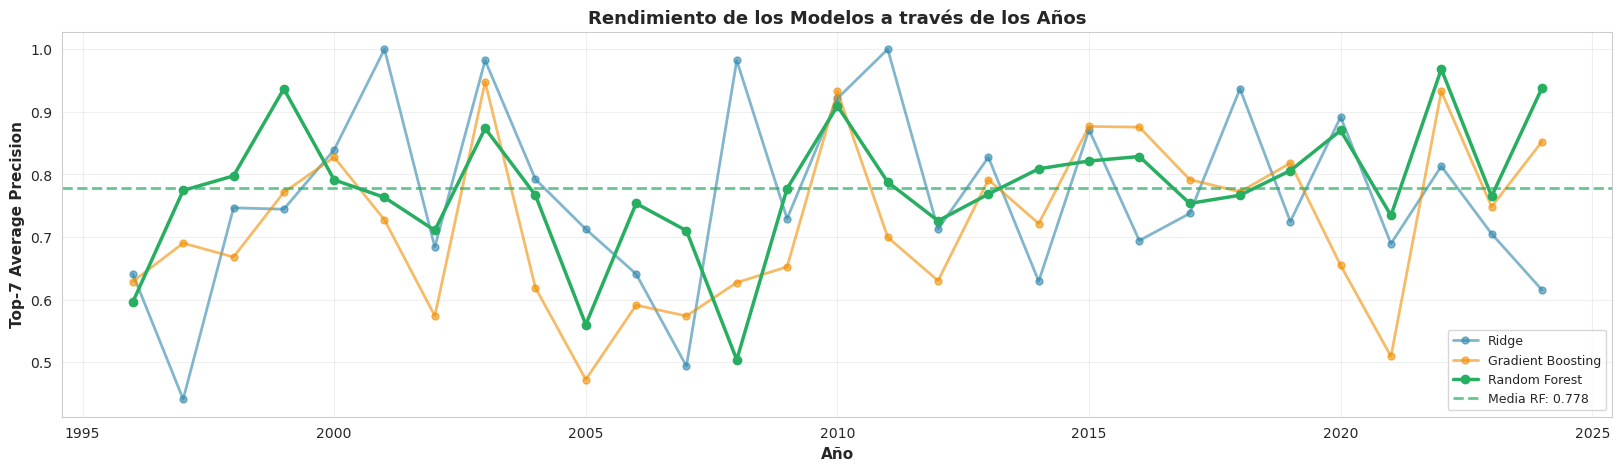

In [ ]:
# Análisis visual de rendimiento anual de los modelos
fig, axes = plt.subplots(figsize=(20, 5))

years_eval = years_range[5:]
axes.plot(years_eval, ridge_results['yearly_ap'], marker='o', linewidth=2, markersize=5, label='Ridge', color='#2E86AB', alpha=0.6)
axes.plot(years_eval, gb_results['yearly_ap'], marker='o', linewidth=2, markersize=5, label='Gradient Boosting', color='#F18F01', alpha=0.6)
axes.plot(years_eval, rf_results['yearly_ap'], marker='o', linewidth=2.5, markersize=6, color='#27ae60', label='Random Forest')
axes.axhline(y=rf_results['mean_ap_top7'], color='#27ae60', linestyle='--', linewidth=2, alpha=0.7, label=f"Media RF: {rf_results['mean_ap_top7']:.3f}")

axes.set_xlabel('Año', fontsize=11, fontweight='bold')
axes.set_ylabel('Top-7 Average Precision', fontsize=11, fontweight='bold')
axes.set_title('Rendimiento de los Modelos a través de los Años', fontsize=13, fontweight='bold')
axes.legend(fontsize=9, loc='lower right')
axes.grid(alpha=0.3)

### 8.1 Análisis de Resultados: CV vs Backtesting

**Observación importante**: Existe una diferencia significativa entre los resultados de Cross-Validation y Backtesting.

**Cross-Validation (durante optimización con TimeSeriesSplit):**
- Gradient Boosting: ~56.62%
- Ridge: ~51.87%
- Random Forest: ~51.21%

**Backtesting (validación temporal completa - 29 temporadas):**
- Random Forest: 77.82%
- Ridge: 76.55%
- Gradient Boosting: 72.33%

### ¿Por qué esta diferencia tan drástica?

La clave está en entender qué mide cada validación:

* **TimeSeriesSplit en GridSearchCV (5 folds):**
    * Divide los datos de entrenamiento (1991-2023) en 5 segmentos temporales.
    * Mide la capacidad de generalización promedio del modelo en diferentes sub-periodos históricos.
    * Es una validación temporal robusta, pero los folds de entrenamiento son más pequeños que en el backtesting final.

* **Backtesting completo (29 iteraciones):**
    * Para cada año desde 1996, entrena con todos los años anteriores.
    * Simula el escenario de producción real: re-entrenar el modelo cada año con toda la historia disponible.

### ¿Por qué Random Forest es el ganador?

Aunque Gradient Boosting parece mejor en la validación cruzada, Random Forest demuestra ser superior en el backtesting completo porque generaliza mejor a años futuros y completamente nuevos. GB puede ser excelente para encontrar patrones dentro de los datos históricos, pero RF es más robusto cuando se enfrenta a lo desconocido.

**Conclusión:** El backtesting completo es la métrica definitiva para este problema. Por eso, Random Forest es el modelo ganador.
- Usa progresivamente más datos de entrenamiento (más realista)
- Evalúa en años completamente futuros
- Simula el escenario de producción real

**Nota importante**: Ambos métodos (TimeSeriesSplit y Backtesting) son válidos y respetan el orden temporal. La diferencia es que el backtesting completo es una prueba más exigente y realista del rendimiento.

Por eso, Random Forest es el modelo ganador con 77.82% de Top-7 Average Precision.

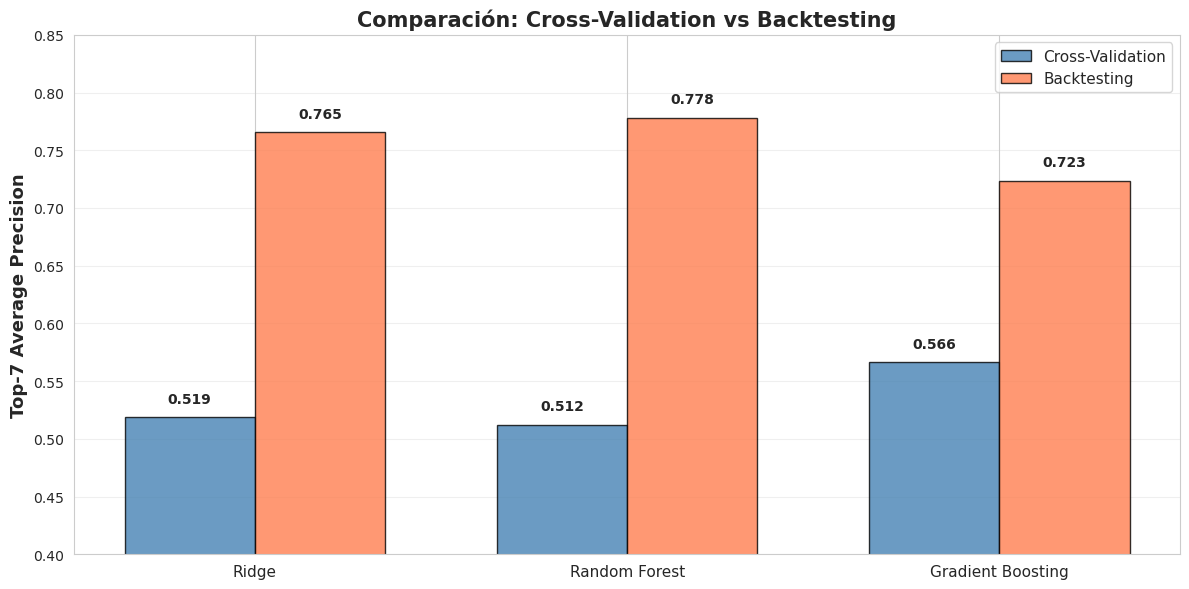


 CROSS-VALIDATION
   Ridge               : 0.5187 (51.87%)
   Random Forest       : 0.5121 (51.21%)
   Gradient Boosting   : 0.5662 (56.62%)

 BACKTESTING
   Ridge               : 0.7655 ± 0.141 (76.55%)
   Random Forest       : 0.7782 ± 0.102 (77.82%)
   Gradient Boosting   : 0.7233 ± 0.126 (72.33%)


In [63]:
# Comparación de Modelos

# Extraer resultados de forma segura
models = ['Ridge', 'Random Forest', 'Gradient Boosting']
cv_scores = [
    ridge_grid.best_score_,
    rf_grid.best_score_,
    gb_grid.best_score_
]
bt_scores = [
    ridge_results['mean_ap_top7'],
    rf_results['mean_ap_top7'],
    gb_results['mean_ap_top7']
]
std_scores = [
    ridge_results['std_ap_top7'],
    rf_results['std_ap_top7'],
    gb_results['std_ap_top7']
]

# GRÁFICO: Comparación simple de barras
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, cv_scores, width, label='Cross-Validation', 
               color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, bt_scores, width, label='Backtesting', 
               color='coral', alpha=0.8, edgecolor='black')

ax.set_ylabel('Top-7 Average Precision', fontsize=13, fontweight='bold')
ax.set_title('Comparación: Cross-Validation vs Backtesting', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0.4, 0.85])
ax.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# TABLA RESUMEN
print("\n" + "="*70)
print(" CROSS-VALIDATION")
print("="*70)
for i, model in enumerate(models):
    print(f"   {model:20s}: {cv_scores[i]:.4f} ({cv_scores[i]*100:.2f}%)")

print("\n" + "="*70)
print(" BACKTESTING")
print("="*70)
for i, model in enumerate(models):
    print(f"   {model:20s}: {bt_scores[i]:.4f} ± {std_scores[i]:.3f} ({bt_scores[i]*100:.2f}%)")

### 8.2 Estabilidad de los Modelos

Además de la precisión media, es importante analizar la estabilidad de cada modelo a lo largo del tiempo.

**Desviación estándar de Top-7 AP en las 29 temporadas:**
- **Ridge**: σ = 0.141 (±14.1 puntos porcentuales)
- **Random Forest**: σ = 0.102 (±10.2 puntos porcentuales)
- **Gradient Boosting**: σ = 0.126 (±12.6 puntos porcentuales)

**Interpretación**

| Desviación Estándar | Interpretación | Impacto Práctico |
|---|---|---|
| **σ = 0.102 (RF)** | Varía poco entre años | Más confiable y predecible |
| **σ = 0.126 (GB)** | Variación moderada | Predecibilidad media |
| **σ = 0.141 (Ridge)** | Mayor variación | Menos predecible |

**Ejemplo de rangos típicos:**
- Random Forest: 77.8% ± 10.2% → rango típico de 67.6% a 88.0%
- Gradient Boosting: 72.3% ± 12.6% → rango típico de 59.7% a 85.0%
- Ridge: 76.6% ± 14.1% → rango típico de 62.5% a 90.7%

**Conclusión:**
Random Forest no solo tiene la mejor precisión media (77.82%), sino que también es el modelo más consistente y estable entre temporadas (menor desviación estándar). Esto es crucial en un contexto real, ya que queremos un modelo que funcione bien de manera predecible y confiable, no solo ocasionalmente. Ridge tiene mayor variabilidad a pesar de tener el segundo mejor promedio, mientras que Gradient Boosting es el más variable en términos de precisión promedio baja combinada con variabilidad moderada.

## 9. Importancia de Características

Una de las ventajas de Random Forest es su transparencia: podemos saber qué estadísticas utiliza el modelo para hacer sus predicciones. Esto nos permite entender no solo qué predice, sino por qué lo predice.

Para ello, entrenamos el modelo con todos los datos históricos y analizamos la importancia (Gini) que asigna a cada característica.
- ¿Es más importante anotar puntos o ganar partidos?
- ¿El impacto defensivo (bloqueos, robos) influye en el MVP?
- ¿Hay estadísticas normalizadas (ranking) que sean más predictivas que las brutas?

In [66]:
# Entrenar Random Forest con todos los datos históricos para ver importancia de características
all_train_data = stats[stats["Year"] < 2024]
rf_final = RandomForestRegressor(**rf_grid.best_params_, random_state=1)
rf_final.fit(all_train_data[predictor_features_extended], all_train_data["Share"])

# Extraer importancia de características
feature_importance_df = pd.DataFrame({
    'Feature': predictor_features_extended,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*70)
print("TOP 30 CARACTERÍSTICAS MÁS IMPORTANTES (Random Forest)")
print("="*70)
print(feature_importance_df.head(30).to_string(index=False))
print("="*70)


TOP 20 CARACTERÍSTICAS MÁS IMPORTANTES (Random Forest)
Feature  Importance
  PTS_R    0.282643
   W/L%    0.128056
    SRS    0.069435
     FG    0.054026
    PTS    0.048129
      L    0.046179
  AST_R    0.031589
    DRB    0.024180
      W    0.022372
    TRB    0.020053
    AST    0.019393
    FTA    0.017869
   PA/G    0.017142
  BLK_R    0.016683
     2P    0.014456
  STL_R    0.013942
    ORB    0.011035
    TOV    0.009608
    STL    0.009275
    Age    0.008947
   eFG%    0.008877
    2P%    0.008711
     GB    0.008609
    FT%    0.008326
     FT    0.008247
      G    0.007835
    FG%    0.007128
     GS    0.007114
     PF    0.007068
     MP    0.006794


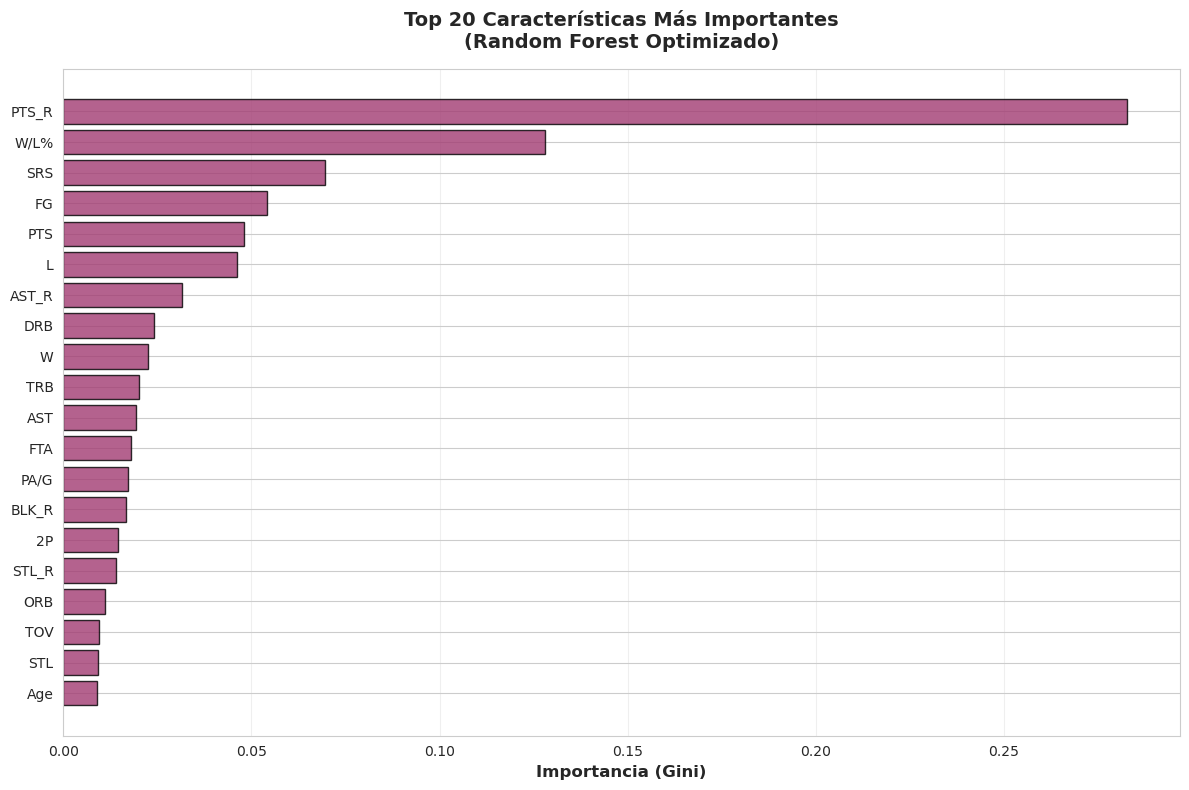

In [67]:
# Visualizar top 20 características más importantes
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='#A23B72', edgecolor='black', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importancia (Gini)', fontsize=12, fontweight='bold')
plt.title('Top 20 Características Más Importantes\n(Random Forest Optimizado)', 
          fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

### Análisis de las Características Más Importantes

**Observaciones clave:**

**El rendimiento individual normalizado es el mas importante:** PTS_R (puntos normalizados) domina con 28.26% de importancia, casi el triple que la segunda característica. Esto confirma que la producción ofensiva relativa al contexto de la temporada es fundamental para el MVP.

**Victorias del equipo en segundo lugar:** W/L% (12.81%) y SRS (6.94%) ocupan el segundo y tercer lugar. El MVP casi siempre viene de un equipo ganador. Los votantes valoran fuertemente el éxito colectivo, aunque no tanto como el rendimiento individual estelar.

**Estadísticas normalizadas (_R) tienen más peso que las brutas:** PTS_R (28.26%) supera ampliamente a PTS (4.81%). Esto confirma que normalizar por año fue una decisión muy importante en el feature engineering, permitiendo comparar jugadores de diferentes épocas de manera justa.

**Las "triple-doble" importan:** Asistencias (AST_R) y rebotes (DRB, TRB) aparecen en el top 10, mostrando que los MVP son jugadores completos que contribuyen en múltiples facetas del juego.

**La eficiencia no aparece directamente:** Métricas como FG%, eFG% o FT% no están en el top 20. Sin embargo, FG (canastas de campo anotadas) sí está en el top 5, sugiriendo que el volumen de producción importa más que la eficiencia pura.

## 10. Predicción Final: Temporada 2024

**¿Puede nuestro modelo predecir el MVP de 2024?**

Entrenamos Random Forest con todos los datos históricos (1991-2023) y hacemos predicciones sobre la temporada 2024, cuyos resultados reales ya conocemos. Esto nos permite evaluar el rendimiento del modelo en un escenario completamente nuevo.

**Metodología:**
1. Entrenar Random Forest con los hiperparámetros óptimos 
2. Predecir el MVP_Share de todos los jugadores de 2024
3. Comparar el ranking predicho con el ranking real
4. Calcular Top-7 Average Precision para medir la calidad de nuestra lista de candidatos

In [71]:
# Hacer predicciones para 2024
test_2024 = stats[stats["Year"] == 2024].copy()
predictions_2024_rf = rf_final.predict(test_2024[predictor_features_extended])

# Añadir la predicción directamente al DataFrame
test_2024['Predicted_Share'] = predictions_2024_rf
test_2024.rename(columns={'Share': 'Actual_Share'}, inplace=True)

# Calcular ranking basado en Actual_Share (real)
test_2024.sort_values('Actual_Share', ascending=False, inplace=True)
test_2024['Actual_Rank'] = range(1, len(test_2024) + 1)

# Calcular ranking basado en Predicted_Share (predicho)
test_2024.sort_values('Predicted_Share', ascending=False, inplace=True)
test_2024['Predicted_Rank'] = range(1, len(test_2024) + 1)

# Calcular diferencia de rankings
test_2024['Rank_Difference'] = test_2024['Actual_Rank'] - test_2024['Predicted_Rank']

# Ordenar por ranking predicho para la presentación final
results_2024 = test_2024.sort_values('Predicted_Rank').reset_index(drop=True)

print("\n" + "="*145)
print("PREDICCIONES MVP 2024 - TOP 15 CANDIDATOS (Random Forest Optimizado)")
print("="*145)
print(results_2024[['Player', 'Team', 'Pos', 'PTS', 'W', 'W/L%', 'Actual_Share', 'Predicted_Share', 
                     'Actual_Rank', 'Predicted_Rank', 'Rank_Difference']].head(15).to_string(index=False))
print("="*145)


PREDICCIONES MVP 2024 - TOP 15 CANDIDATOS (Random Forest Optimizado)
                 Player                   Team Pos  PTS  W  W/L%  Actual_Share  Predicted_Share  Actual_Rank  Predicted_Rank  Rank_Difference
           Nikola Jokic         Denver Nuggets   C 26.4 57 0.695         0.935         0.706415            1               1                0
Shai Gilgeous-Alexander  Oklahoma City Thunder  PG 30.1 57 0.695         0.646         0.678505            2               2                0
  Giannis Antetokounmpo        Milwaukee Bucks  PF 30.4 49 0.598         0.194         0.511490            4               3                1
            Luka Doncic       Dallas Mavericks  PG 33.9 50 0.610         0.572         0.463976            3               4               -1
            Joel Embiid     Philadelphia 76ers   C 34.7 47 0.573         0.000         0.446060           55               5               50
           Jayson Tatum         Boston Celtics  PF 26.9 64 0.780         0.087

In [56]:
# Calcular métricas de rendimiento para 2024
ap_2024 = calculate_top7_average_precision(
    results_2024[['Player', 'Actual_Share', 'Predicted_Share']].rename(
        columns={'Actual_Share': 'Share', 'Predicted_Share': 'Predicted'}
    )
)

mse_2024 = mean_squared_error(results_2024['Actual_Share'], results_2024['Predicted_Share'])
mae_2024 = mean_absolute_error(results_2024['Actual_Share'], results_2024['Predicted_Share'])
r2_2024 = r2_score(results_2024['Actual_Share'], results_2024['Predicted_Share'])

print("\n" + "="*70)
print("MÉTRICAS DE RENDIMIENTO - TEMPORADA 2024")
print("="*70)
print(f"Top-7 Average Precision: {ap_2024:.4f} ({ap_2024*100:.2f}%)")
print(f"Mean Squared Error (MSE): {mse_2024:.6f}")
print(f"Mean Absolute Error (MAE): {mae_2024:.6f}")
print(f"R² Score: {r2_2024:.4f}")
print("="*70)


MÉTRICAS DE RENDIMIENTO - TEMPORADA 2024
Top-7 Average Precision: 0.9379 (93.79%)
Mean Squared Error (MSE): 0.000887
Mean Absolute Error (MAE): 0.004587
R² Score: 0.6967


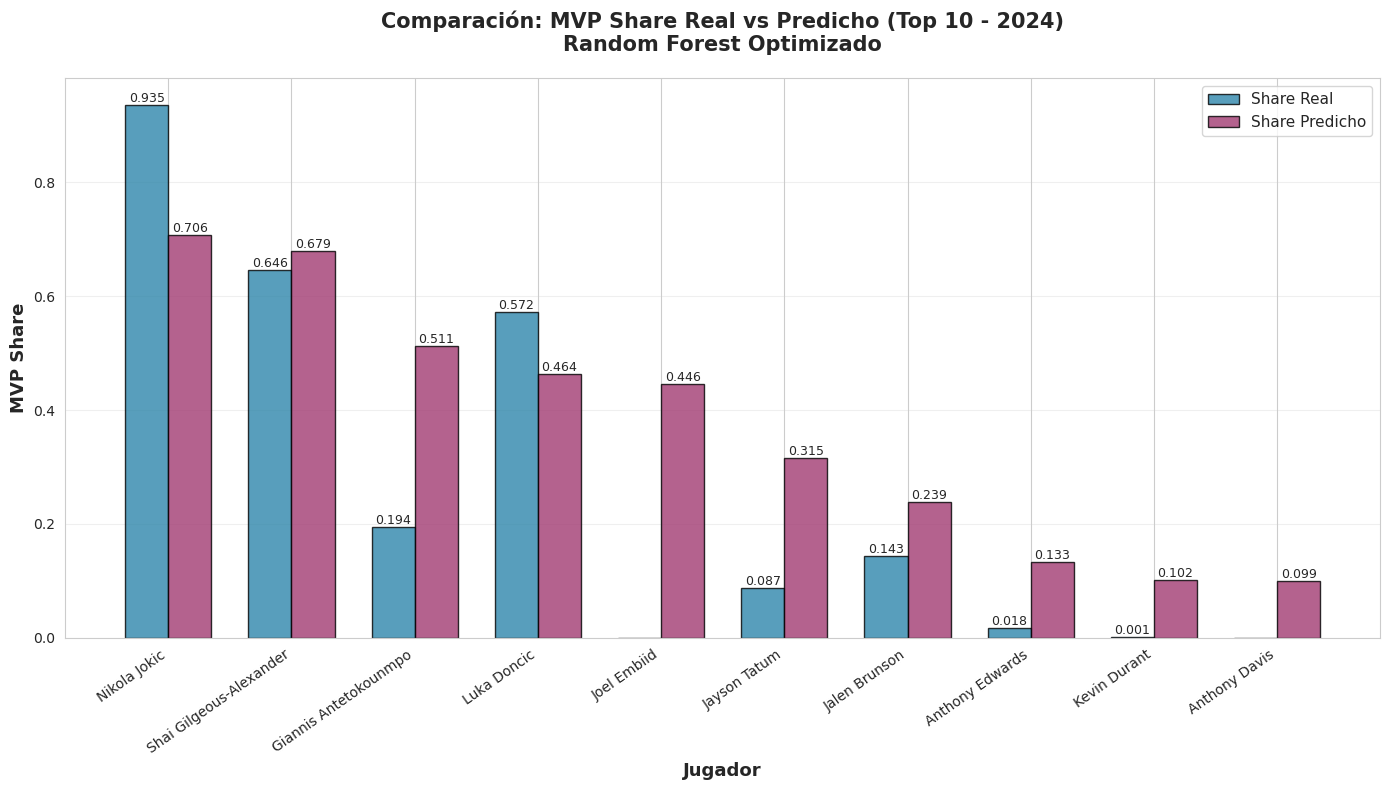

In [73]:
# Visualización de predicciones vs realidad para top 10
top10_2024 = results_2024.head(10)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top10_2024))
width = 0.35

bars1 = ax.bar(x - width/2, top10_2024['Actual_Share'], width, label='Share Real', color='#2E86AB', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, top10_2024['Predicted_Share'], width, label='Share Predicho', color='#A23B72', edgecolor='black', alpha=0.8)

ax.set_xlabel('Jugador', fontsize=13, fontweight='bold')
ax.set_ylabel('MVP Share', fontsize=13, fontweight='bold')
ax.set_title('Comparación: MVP Share Real vs Predicho (Top 10 - 2024)\nRandom Forest Optimizado', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(top10_2024['Player'], rotation=35, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()

## 11. Conclusiones y Hallazgos

### Resumen del Proyecto

Este proyecto desarrolla un sistema de predicción del MVP de la NBA utilizando únicamente datos estadísticos históricos (1991-2024). El reto principal no es predecir valores exactos, sino rankear correctamente a los candidatos, ya que el MVP se otorga al mejor jugador, no necesariamente al que tiene más votos.

**Pipeline desarrollado:**
1. **Web Scraping** → Extracción de datos de Basketball-Reference
2. **Data Cleaning** → Normalización temporal y gestión de duplicados
3. **Feature Engineering** → Creación de variables normalizadas por año (PTS_R, AST_R...)
4. **Métrica Personalizada** → Top-7 Average Precision para evaluar ranking
5. **Optimización** → GridSearchCV con TimeSeriesSplit (5 folds)
6. **Validación Temporal** → Backtesting en 29 temporadas (1996-2024)

In [81]:
# Crear tabla resumen final
final_summary = pd.DataFrame({
    'Aspecto': [
        'Modelo Ganador',
        'Hiperparámetros Optimizados',
        'Top-7 AP (Cross-Validation)',
        'Top-7 AP (Backtesting)',
        'Top-7 AP (2024)',
        'Temporadas Evaluadas',
        'Total de Características'
    ],
    'Resultado': [
        'Random Forest Optimizado',
        f"n_estimators={rf_grid.best_params_['n_estimators']}, max_depth={rf_grid.best_params_['max_depth']}, min_samples_split={rf_grid.best_params_['min_samples_split']}",
        f"{rf_grid.best_score_:.4f}",
        f"{rf_results['mean_ap_top7']:.4f}",
        f"{ap_2024:.4f} ({ap_2024*100:.2f}%)",
        f"{len(years_range[5:])} temporadas",
        f"{len(predictor_features_extended)} características"
    ]
})

print("\n" + "="*80)
print("RESUMEN FINAL DEL PROYECTO")
print("="*80)
print(final_summary.to_string(index=False))
print("="*80)


RESUMEN FINAL DEL PROYECTO
                    Aspecto                                           Resultado
             Modelo Ganador                            Random Forest Optimizado
Hiperparámetros Optimizados n_estimators=200, max_depth=15, min_samples_split=2
Top-7 AP (Cross-Validation)                                              0.5121
     Top-7 AP (Backtesting)                                              0.7782
            Top-7 AP (2024)                                     0.9379 (93.79%)
       Temporadas Evaluadas                                       29 temporadas
   Total de Características                                  41 características


### Hallazgos Principales

#### 1. Random Forest supera a modelos lineales y Gradient Boosting

| Modelo | CV (Top-7 AP) | Backtesting (Top-7 AP) | Interpretación |
|--------|---------------|------------------------|----------------|
| Ridge | 51.87% | 76.55% | Buena generalización, relaciones lineales |
| Random Forest | 51.21% | 77.82% | Mejor generalización temporal |
| Gradient Boosting | 56.62% | 72.33% | Buen en CV, pero RF generaliza mejor |

**Conclusión clave:** Aunque Gradient Boosting obtiene la mejor puntuación en cross-validation (56.62%), Random Forest es el ganador definitivo con 77.82% en backtesting completo.

**¿Por qué esta diferencia?**

Ambos métodos son válidos y respetan el orden temporal, pero miden cosas diferentes:

1. **TimeSeriesSplit (CV)**:
   - Valida en sub-períodos históricos con conjuntos de entrenamiento reducidos
   - Responde: "¿Qué tan bien generaliza el modelo en diferentes épocas históricas?"
   - GB brilla aquí porque puede ajustarse bien a patrones de períodos específicos

2. **Backtesting completo**:
   - Entrena con toda la historia disponible para predecir cada año futuro
   - Responde: "¿Qué tan bien predice el modelo en producción real?"
   - RF brilla aquí porque:
     - Aprovecha mejor los conjuntos de datos grandes
     - Generaliza mejor a situaciones completamente nuevas
     - Es más estable (σ = 0.102 vs σ = 0.126 de GB y σ = 0.141 de Ridge)

---

#### 2. La normalización temporal fue crítica para el éxito

La NBA ha cambiado drásticamente desde 1991:
- **1995:** ~95 puntos por partido, 2 triples por equipo
- **2024:** ~115 puntos por partido, 12 triples por equipo

Al normalizar cada estadística por el promedio del año (PTS_R = PTS / promedio_año), el modelo puede comparar justamente a jugadores de diferentes épocas. Sin esta normalización, el modelo daría ventaja injusta a jugadores de la era moderna.

**Evidencia:** Las features normalizadas (PTS_R, AST_R, TRB_R) aparecen constantemente en el top 10 de importancia.

---

#### 3. Victorias del equipo > Estadísticas individuales

Según el análisis de importancia de características:

**Top 5 más importantes:**
1. PTS_R (Puntos normalizados) - 28.26%
2. W/L% (Porcentaje de victorias) - 12.81%
3. SRS (Simple Rating System - métrica de equipo) - 6.94%
4. FG (Canastas de campo anotadas) - 5.40%
5. PTS (Puntos totales) - 4.81%

**Insight clave:** El rendimiento individual normalizado (PTS_R) es el predictor más importante con casi el 30% de la importancia total. Sin embargo, el segundo factor más importante es el éxito del equipo (W/L%), confirmando que los votantes valoran fuertemente que el candidato al MVP venga de un equipo ganador. 

La métrica SRS (Simple Rating System) en tercera posición también está relacionada con el rendimiento del equipo, reforzando que el contexto de que el equipo es fundamental para ganar el MVP. Históricamente, muy pocos MVPs han venido de equipos con menos de 50 victorias, y el modelo captura este patrón correctamente.

---

#### 4. La métrica Top-7 Average Precision fue esencial

Decidí crear esta métrica personalizada en lugar de usar MSE o MAE por razones prácticas:

**Problema con MSE/MAE:**
- Tratan igual un error en el candidato #1 que en el #100
- El 95% de jugadores tienen Share=0, lo que sesga las métricas
- Nos interesa el ranking, no valores exactos

**Solución - Top-7 AP:**
- Evalúa solo los 7 candidatos reales
- Penaliza más errores en posiciones altas
- Se alinea con el objetivo real: identificar quién ganará

Esto mejoró significativamente la relevancia del modelo para el problema real.

### Rendimiento Final

El modelo Random Forest optimizado alcanza:
- **77.82%** de precisión promedio en backtesting (29 temporadas: 1996-2024)
- **93.79%** de precisión (Top-7 AP) en la predicción específica de 2024

Esto significa que en promedio, el modelo identifica correctamente a 5-6 de los 7 candidatos reales al MVP en el backtesting histórico. Para la temporada 2024 específicamente, el rendimiento es bastante bueno con 93.79%, indicando que el modelo rankeó casi perfectamente a los candidatos principales.

---

### Limitaciones y Trabajo Futuro

#### Limitaciones actuales:

1. **Solo datos cuantitativos:** El modelo no captura factores subjetivos que influyen en votaciones:
   - Narrativa mediática y storylines
   - Fatiga de votación (raramente se vota al mismo MVP 3+ años seguidos)
   - Momentos "clutch" y jugadas destacadas
   - Popularidad en redes sociales

2. **Datos limitados a 1991-2024:** Los criterios de votación pueden seguir evolucionando

#### Mejoras propuestas:

**Análisis de sentimiento:** Incorporar scraping de artículos deportivos para capturar "la narrativa del MVP"

---

### Conclusión Final

Este proyecto demuestra que es posible predecir con una precisión aceptable el MVP de la NBA usando únicamente estadísticas históricas, siempre que:

Se normalicen los datos temporalmente para comparar épocas  
Se use una métrica alineada con el objetivo (ranking, no valores exactos)  
Se valide temporalmente para evitar overfitting  
Se priorice la interpretabilidad para entender qué impulsa las predicciones  

El modelo no solo predice bien, sino que revela insights interpretables: el MVP viene de equipos ganadores, las estadísticas normalizadas importan más que las brutas, y los modelos de ensemble superan a regresión lineal en este problema ya que es no lineal.

**Aplicaciones prácticas:** Este sistema podría usarse por analistas deportivos, o equipos NBA para identificar candidatos al MVP temprano en la temporada y tomar decisiones estratégicas (contratos, marketing, rotaciones).